In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
#Cargo BD
path= "dataset_demand_acumulate.csv"
df = pd.read_csv(path)

limpieza y tranformaciones

In [3]:
# Aseguro que las columnas tengan nombres estándar
df.columns = [col.strip().lower() for col in df.columns]

In [4]:
# convierto fecha a datetime
df['year_month'] = pd.to_datetime(df['year_month'], errors='coerce')

In [5]:
# Ordeno cronológicamente
df = df.sort_values('year_month').reset_index(drop=True)

# Elimino valores nulos o duplicados
df = df.dropna(subset=['year_month', 'demand'])
df = df.drop_duplicates(subset='year_month')

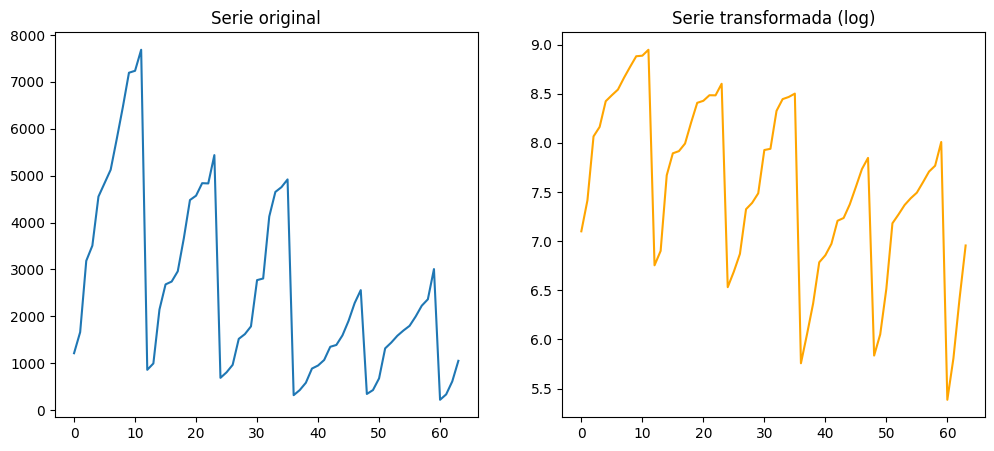

In [6]:
# Realizo ambas gráficas
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(df['demand'], label='Original')
plt.title('Serie original')

plt.subplot(1,2,2)
plt.plot(np.log1p(df['demand']), label='Log(1 + Demand)', color='orange')
plt.title('Serie transformada (log)')
plt.show()


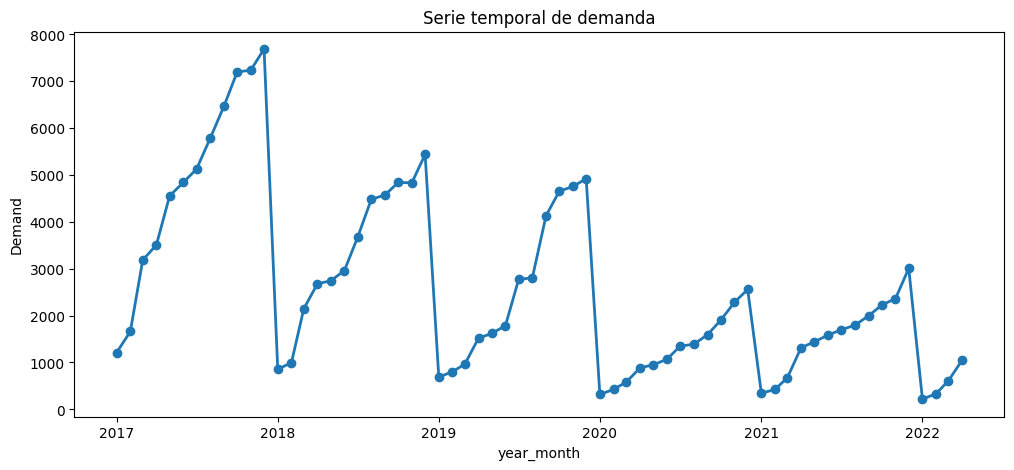

In [7]:
# grafica de la serie
plt.figure(figsize=(12,5))
plt.plot(df['year_month'], df['demand'], marker='o', linewidth=2)
plt.title('Serie temporal de demanda')
plt.xlabel('year_month')
plt.ylabel('Demand')
plt.show()

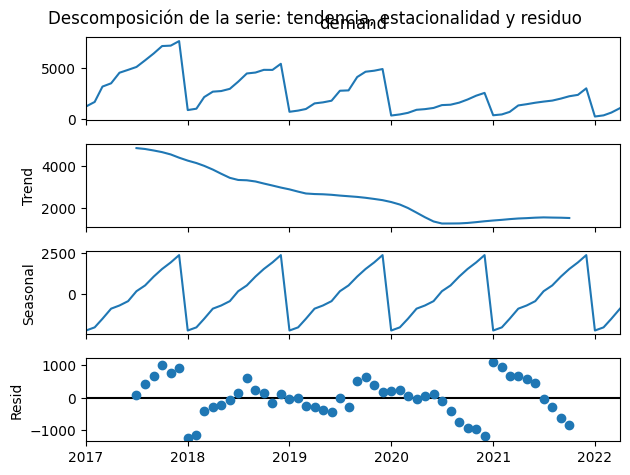

In [8]:
# descompongo la serie
df = df.set_index('year_month')
result = seasonal_decompose(df['demand'], model='additive', period=12)

result.plot()
plt.suptitle('Descomposición de la serie: tendencia, estacionalidad y residuo', fontsize=12)
plt.show()

In [9]:
# prueba de estacionalidad ADF
adf_test = adfuller(df['demand'])
print("=== Prueba de Dickey-Fuller Aumentada ===")
print(f"Estadístico ADF: {adf_test[0]:.4f}")
print(f"p-valor: {adf_test[1]:.4f}")
if adf_test[1] < 0.05:
    print("✅ La serie es estacionaria (no necesita diferenciación).")
else:
    print("⚠️ La serie NO es estacionaria (podría necesitar diferenciación).")

=== Prueba de Dickey-Fuller Aumentada ===
Estadístico ADF: -4.4410
p-valor: 0.0003
✅ La serie es estacionaria (no necesita diferenciación).


MODELO SARIMA

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

In [11]:
# Transformación logarítmica
df['log_demand'] = np.log1p(df['demand'])  # log(1+x) evita errores con ceros

# División temporal (train hasta 2021-12 / valid 2022-01 a 2022-04)
train = df.loc[:'2021-12', 'log_demand']
valid = df.loc['2022-01':, 'log_demand']

print(f"Entrenamiento: {train.index.min()} → {train.index.max()} ({len(train)} registros)")
print(f"Validación: {valid.index.min()} → {valid.index.max()} ({len(valid)} registros)")

Entrenamiento: 2017-01-01 00:00:00 → 2021-12-01 00:00:00 (60 registros)
Validación: 2022-01-01 00:00:00 → 2022-04-01 00:00:00 (4 registros)


In [12]:
# Busqueda automática de parámetros
stepwise_fit = auto_arima(train, 
                          seasonal=True, m=12,
                          d=0, D=1, 
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-17.034, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=41.481, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-18.607, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=64.272, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-9.711, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-20.710, Time=0.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=25.184, Time=0.35 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-19.373, Time=0.81 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-19.221, Time=0.96 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1.462, Time=0.44 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-16.841, Time=1.29 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=-18.433,

In [13]:
# Ajuste del modelo SARIMA
model = SARIMAX(train,
                order=stepwise_fit.order,
                seasonal_order=stepwise_fit.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

c:\Users\Acer\anaconda3\envs\curso_deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Acer\anaconda3\envs\curso_deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         log_demand   No. Observations:                   60
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                  14.580
Date:                            Wed, 05 Nov 2025   AIC                            -21.161
Time:                                    10:33:30   BIC                            -16.619
Sample:                                01-01-2017   HQIC                           -20.018
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9497      0.052     18.430      0.000       0.849       1.051
ar.S.L12      -0.6339      0.096   

In [14]:
# Pronóstico sobre la validación (Ene–Abr 2022)
forecast = results.get_forecast(steps=len(valid))
pred_mean_log = forecast.predicted_mean
conf_int_log = forecast.conf_int()

# Revertir de log → escala original
y_pred = np.expm1(pred_mean_log)
conf_int = np.expm1(conf_int_log)
y_true = np.expm1(valid)


In [15]:
# Evaluación del modelo
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print("\n=== MÉTRICAS DE VALIDACIÓN ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")


=== MÉTRICAS DE VALIDACIÓN ===
MAE  : 73.73
RMSE : 77.30
MAPE : 21.14%
R²   : 0.9417


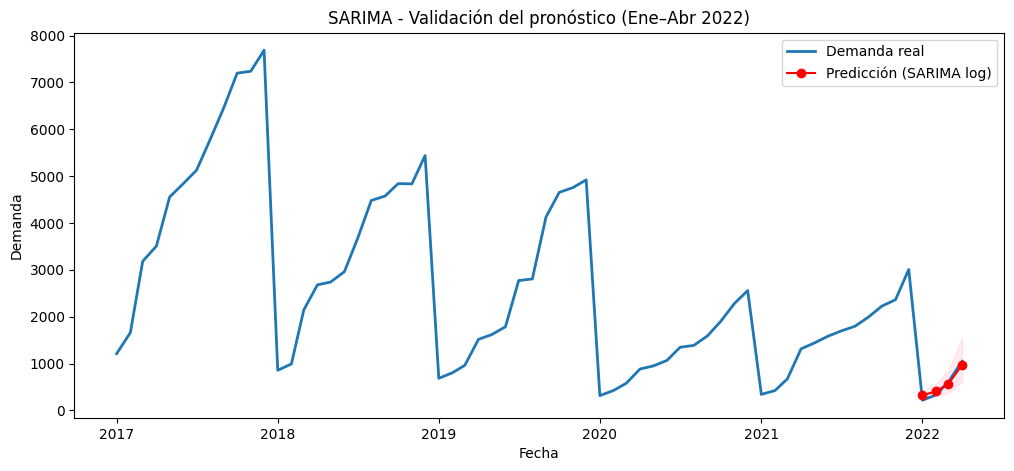

In [16]:
# Visualización del pronóstico
plt.figure(figsize=(12,5))
plt.plot(df.index, df['demand'], label='Demanda real', linewidth=2)
plt.plot(valid.index, y_pred, color='red', marker='o', label='Predicción (SARIMA log)')
plt.fill_between(valid.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('SARIMA - Validación del pronóstico (Ene–Abr 2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

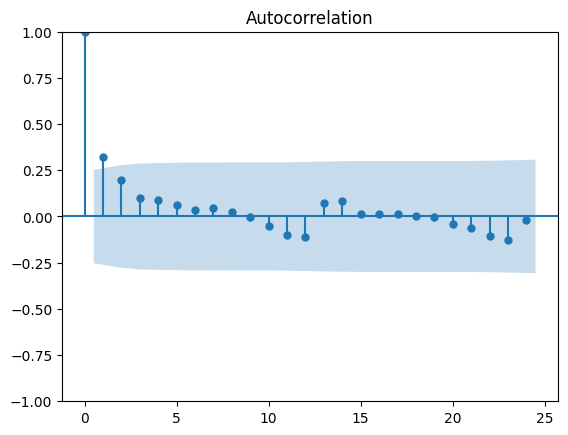

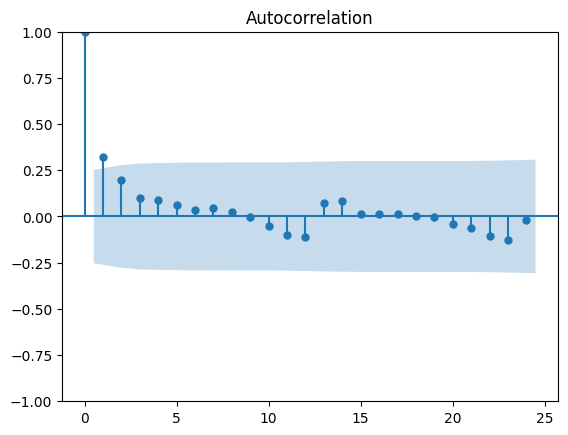

In [17]:
# grafico residuos
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(results.resid, lags=24)


In [18]:
# Reentrenamiento del modelo
train_full = df.loc[:'2022-04', 'log_demand']

model_full = SARIMAX(train_full,
                     order=stepwise_fit.order,
                     seasonal_order=stepwise_fit.seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

results_full = model_full.fit(disp=False)
print(results_full.summary())

c:\Users\Acer\anaconda3\envs\curso_deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Acer\anaconda3\envs\curso_deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         log_demand   No. Observations:                   64
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                  14.235
Date:                            Wed, 05 Nov 2025   AIC                            -20.471
Time:                                    10:33:31   BIC                            -15.287
Sample:                                01-01-2017   HQIC                           -18.929
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9377      0.060     15.688      0.000       0.821       1.055
ar.S.L12      -0.6597      0.111   

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Obtener residuos del modelo final
resid = results_full.resid

# Prueba de Ljung-Box con 36 rezagos (1 año si la serie es mensual)
ljung_box_results = acorr_ljungbox(resid, lags=[36], return_df=True)
print(ljung_box_results)


      lb_stat  lb_pvalue
36  27.232701   0.853399


In [20]:
# predicción
forecast_full = results_full.get_forecast(steps=3)
pred_mean_log = forecast_full.predicted_mean
conf_int_log = forecast_full.conf_int()

# Revertir transformación logarítmica
future_mean = np.expm1(pred_mean_log)
conf_int = np.expm1(conf_int_log)

# Crear fechas para los próximos tres meses
future_dates = pd.date_range(start='2022-05-01', periods=3, freq='MS')

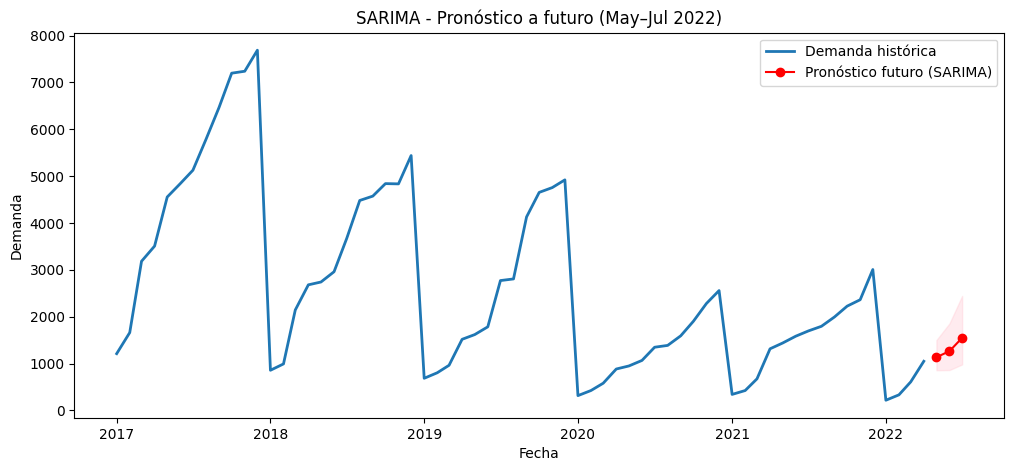

In [21]:
# Grafico historico mas predicción
plt.figure(figsize=(12,5))
plt.plot(df.index, df['demand'], label='Demanda histórica', linewidth=2)
plt.plot(future_dates, future_mean, 'ro-', label='Pronóstico futuro (SARIMA)')
plt.fill_between(future_dates,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('SARIMA - Pronóstico a futuro (May–Jul 2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

In [22]:
# UNIR LOS DATOS HISTÓRICOS Y PREDICCIONES
forecast_df = pd.DataFrame({
    'Fecha': future_dates,
    'Pronostico': future_mean.values,
    'LI': conf_int.iloc[:, 0].values,
    'LS': conf_int.iloc[:, 1].values
})
print(forecast_df)

# Guardar archivo con histórico + predicción
df_out = df.copy()
df_out = df_out[['demand']].reset_index()
df_out = pd.concat([
    df_out,
    pd.DataFrame({
        'year_month': future_dates,
        'demand': future_mean.values
    })
], ignore_index=True)

df_out.to_excel('pronostico_SARIMA_may_jul_2022.xlsx', index=False)
print("✅ Archivo exportado: pronostico_SARIMA_may_jul_2022.xlsx")

       Fecha   Pronostico          LI           LS
0 2022-05-01  1134.029600  856.911636  1500.660704
1 2022-06-01  1264.827603  861.425919  1856.921340
2 2022-07-01  1548.259192  981.047771  2443.080741
✅ Archivo exportado: pronostico_SARIMA_may_jul_2022.xlsx
